# Scaling Law Exploration

This notebook explores transformer scaling laws. It trains models on OpenWebText using the Triton implementation and sweeps across a wide range of (small) FLOPs budgets, model sizes, and learning rates. From these results it fits IsoFLOP curves, finds the minimums, and then derives the scaling laws to give the optimal model size and tokens for a given training FLOPs budget.

In [1345]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit

## Model Training Results

In [1347]:
def transformer_stats(depth: int, d_model: int, d_ff: int, seq_len: int):
    stats = {}

    # params
    params = 0
    # attention
    params += d_model             # RMS scale
    params += d_model * 3*d_model # QKV
    params += d_model * d_model   # Out
    # feedforward
    params += d_model             # RMS scale
    params += d_model * 2*d_ff    # GLU up
    params += d_model * d_ff      # GLU down

    params *= depth
    params += d_model # Output head norm

    stats["params"] = params

    # FLOPs (matmuls)
    flops = 0
    # attention
    flops += seq_len * (2 * d_model * 3*d_model) # QKV
    flops += seq_len * seq_len * d_model * 2     # A=QK
    flops += seq_len * seq_len * d_model * 2     # AV
    flops += seq_len * (2 * d_model * d_model)   # Out
    # feedforward
    flops += seq_len * (2 * d_model * 2*d_ff)
    flops += seq_len * (2 * d_model * d_ff)

    flops *= depth

    stats["flops_per_token"] = flops // seq_len

    return stats

In [1348]:
device_flops = 71e12
efficiency = 0.6
act_device_flops = efficiency * device_flops

# seconds = 60*7.5
# seconds = 60*30
# seconds = 60*120
seconds = 60*480

total_flops = seconds * act_device_flops
total_flops

1.22688e+18

In [1349]:
batch_size = 32
seq_len = 256

depth_width_ratio = 25
d_model = 128+64

d_ff = int(64*((d_model*4*(2/3)) // 64))

print(f"{d_model=}, depth={round(d_model/depth_width_ratio)}, {d_ff=}")

d_model=192, depth=8, d_ff=512


In [1350]:
model_configs = [
    {"depth":  5, "d_model":  128, "d_ff":  320, "seq_len": seq_len},
    {"depth":  8, "d_model":  192, "d_ff":  512, "seq_len": seq_len},
    {"depth": 10, "d_model":  256, "d_ff":  640, "seq_len": seq_len},
    {"depth": 13, "d_model":  320, "d_ff":  832, "seq_len": seq_len},
    {"depth": 15, "d_model":  384, "d_ff": 1024, "seq_len": seq_len},
    {"depth": 18, "d_model":  448, "d_ff": 1152, "seq_len": seq_len},
    {"depth": 20, "d_model":  512, "d_ff": 1344, "seq_len": seq_len},
    {"depth": 23, "d_model":  576, "d_ff": 1536, "seq_len": seq_len},
    {"depth": 26, "d_model":  640, "d_ff": 1664, "seq_len": seq_len},
    {"depth": 31, "d_model":  768, "d_ff": 2048, "seq_len": seq_len},
    {"depth": 36, "d_model":  896, "d_ff": 2368, "seq_len": seq_len},
    {"depth": 41, "d_model": 1024, "d_ff": 2688, "seq_len": seq_len},
]

In [1351]:
for mc in model_configs:
    stats = transformer_stats(mc["depth"], mc["d_model"], mc["d_ff"], mc["seq_len"])
    total_tokens = total_flops / ((stats["flops_per_token"] / 2) * 6)
    tokens_per_batch = batch_size * seq_len
    total_steps = total_tokens / tokens_per_batch
    mc["params"] = stats["params"]
    mc["flops_per_token"] = stats["flops_per_token"]
    mc["total_flops"] = total_flops
    mc["total_steps"] = round(total_steps)
    print(mc)

{'depth': 5, 'd_model': 128, 'd_ff': 320, 'seq_len': 256, 'params': 943488, 'flops_per_token': 2539520, 'total_flops': 1.22688e+18, 'total_steps': 19657996}
{'depth': 8, 'd_model': 192, 'd_ff': 512, 'seq_len': 256, 'params': 3542208, 'flops_per_token': 8650752, 'total_flops': 1.22688e+18, 'total_steps': 5770813}
{'depth': 10, 'd_model': 256, 'd_ff': 640, 'seq_len': 256, 'params': 7542016, 'flops_per_token': 17694720, 'total_flops': 1.22688e+18, 'total_steps': 2821287}
{'depth': 13, 'd_model': 320, 'd_ff': 832, 'seq_len': 256, 'params': 15716800, 'flops_per_token': 35676160, 'total_flops': 1.22688e+18, 'total_steps': 1399306}
{'depth': 15, 'd_model': 384, 'd_ff': 1024, 'seq_len': 256, 'params': 26553984, 'flops_per_token': 58982400, 'total_flops': 1.22688e+18, 'total_steps': 846386}
{'depth': 18, 'd_model': 448, 'd_ff': 1152, 'seq_len': 256, 'params': 42336448, 'flops_per_token': 92897280, 'total_flops': 1.22688e+18, 'total_steps': 537388}
{'depth': 20, 'd_model': 512, 'd_ff': 1344, 'se

In [1352]:
model_results = [
    ################################################################################
    # 1.917e+16 FLOPs
    ################################################################################
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':     2_539_520, 'total_flops': 1.917e+16, 'total_steps':  307156, 'lr':  45e-4, 'min_valid_loss': 4.134929395112835}, # 500k eval
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':     2_539_520, 'total_flops': 1.917e+16, 'total_steps':  307156, 'lr':  54e-4, 'min_valid_loss': 4.116206239481441}, # 500k eval
    
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':     8_650_752, 'total_flops': 1.917e+16, 'total_steps':   90169, 'lr':  36e-4, 'min_valid_loss': 4.015703283372472}, # 500k eval
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':     8_650_752, 'total_flops': 1.917e+16, 'total_steps':   90169, 'lr':  45e-4, 'min_valid_loss': 3.966380322565798}, # 500k eval
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':     8_650_752, 'total_flops': 1.917e+16, 'total_steps':   90169, 'lr':  54e-4, 'min_valid_loss': 3.985661569188853}, # 500k eval

    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':    17_694_720, 'total_flops': 1.917e+16, 'total_steps':   44083, 'lr':   9e-4, 'min_valid_loss': 4.025171451881284}, # 500k eval
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':    17_694_720, 'total_flops': 1.917e+16, 'total_steps':   44083, 'lr':  18e-4, 'min_valid_loss': 3.9786361358204827}, # 500k eval
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':    17_694_720, 'total_flops': 1.917e+16, 'total_steps':   44083, 'lr':  27e-4, 'min_valid_loss': 3.9435650872402506}, # 500k eval
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':    17_694_720, 'total_flops': 1.917e+16, 'total_steps':   44083, 'lr':  36e-4, 'min_valid_loss': 3.9442613945632683}, # 500k eval

    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 1.917e+16, 'total_steps':   21864, 'lr':   9e-4, 'min_valid_loss': 4.018190954552322}, # 500k eval
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 1.917e+16, 'total_steps':   21864, 'lr':  18e-4, 'min_valid_loss': 4.00642749911449}, # 500k eval
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 1.917e+16, 'total_steps':   21864, 'lr':  27e-4, 'min_valid_loss': 4.653605891055748}, # 500k eval
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 1.917e+16, 'total_steps':   21864, 'lr':  36e-4, 'min_valid_loss': 5.621643683949455}, # 500k eval

    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 1.917e+16, 'total_steps':   13225, 'lr':   9e-4, 'min_valid_loss': 4.105352604975466}, # 500k eval
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 1.917e+16, 'total_steps':   13225, 'lr':  18e-4, 'min_valid_loss': 4.248595206463923}, # 500k eval
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 1.917e+16, 'total_steps':   13225, 'lr':  27e-4, 'min_valid_loss': 5.085354320338515}, # 500k eval

    ################################################################################    
    # 7.668e+16 FLOPs
    ################################################################################
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':    2_539_520, 'total_flops': 7.668e+16, 'total_steps': 1228625, 'lr':  36e-4, 'min_valid_loss': 4.0648709535598755},
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':    2_539_520, 'total_flops': 7.668e+16, 'total_steps': 1228625, 'lr':  45e-4, 'min_valid_loss': 4.043936649958293},
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':    2_539_520, 'total_flops': 7.668e+16, 'total_steps': 1228625, 'lr':  54e-4, 'min_valid_loss': 4.069636364777883},

    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':    8_650_752, 'total_flops': 7.668e+16, 'total_steps':  360676, 'lr':  45e-4, 'min_valid_loss': 3.824283500512441},
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':    8_650_752, 'total_flops': 7.668e+16, 'total_steps':  360676, 'lr':  54e-4, 'min_valid_loss': 3.805178145567576},
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':    8_650_752, 'total_flops': 7.668e+16, 'total_steps':  360676, 'lr':  63e-4, 'min_valid_loss': 3.8373729983965554},
    
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':   3e-4, 'min_valid_loss': 3.8506069779396057},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':   9e-4, 'min_valid_loss': 3.7916154861450195},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  18e-4, 'min_valid_loss': 3.7921804785728455},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  27e-4, 'min_valid_loss': 3.7581790486971536},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  36e-4, 'min_valid_loss': 3.752914845943451},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  45e-4, 'min_valid_loss': 3.7440483768781028},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  54e-4, 'min_valid_loss': 3.7524999380111694},

    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  18e-4, 'min_valid_loss': 3.7271199226379395},
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  27e-4, 'min_valid_loss': 3.7156808376312256},
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  36e-4, 'min_valid_loss': 5.813830455144246},
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  45e-4, 'min_valid_loss': None},
    
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':   3e-4, 'min_valid_loss': 3.7982228795687356},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':   9e-4, 'min_valid_loss': 3.734954277674357},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':  18e-4, 'min_valid_loss': 3.706389546394348},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':  27e-4, 'min_valid_loss': None},

    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':   92_897_280, 'total_flops': 7.668e+16, 'total_steps':   33587, 'lr':   3e-4, 'min_valid_loss': 3.8258202274640403},
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':   92_897_280, 'total_flops': 7.668e+16, 'total_steps':   33587, 'lr':   9e-4, 'min_valid_loss': 3.7197481592496238},
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':   92_897_280, 'total_flops': 7.668e+16, 'total_steps':   33587, 'lr':  18e-4, 'min_valid_loss': 4.565386533737183},

    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':   1e-4, 'min_valid_loss': 4.251430074373881},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':   3e-4, 'min_valid_loss': 3.8821765780448914},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':   9e-4, 'min_valid_loss': 3.7999677856763205},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':  18e-4, 'min_valid_loss': 4.894144376118978},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':  27e-4, 'min_valid_loss': 5.652546604474385},

    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':  196_706_304, 'total_flops': 7.668e+16, 'total_steps':   15862, 'lr':   1e-4, 'min_valid_loss': 4.353442509969075},
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':  196_706_304, 'total_flops': 7.668e+16, 'total_steps':   15862, 'lr':   3e-4, 'min_valid_loss': 3.9399943947792053},
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':  196_706_304, 'total_flops': 7.668e+16, 'total_steps':   15862, 'lr':   9e-4, 'min_valid_loss': 3.9679184754689536},

    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':  268_369_920, 'total_flops': 7.668e+16, 'total_steps':   11626, 'lr':   1e-4, 'min_valid_loss': 4.442907333374023},
    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':  268_369_920, 'total_flops': 7.668e+16, 'total_steps':   11626, 'lr':   3e-4, 'min_valid_loss': 4.027829925219218},
    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':  268_369_920, 'total_flops': 7.668e+16, 'total_steps':   11626, 'lr':   9e-4, 'min_valid_loss': 4.179373860359192},
    
    ################################################################################
    # 3.0672e+17 FLOPS
    ################################################################################
    # {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':     2_539_520, 'total_flops': 3.067e+17, 'total_steps': 4914499, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':     8_650_752, 'total_flops': 3.067e+17, 'total_steps': 1442703, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':    17_694_720, 'total_flops': 3.067e+17, 'total_steps':  705322, 'lr':   1e-4, 'min_valid_loss': },

    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 3.067e+17, 'total_steps':  349827, 'lr':  18e-4, 'min_valid_loss': 3.543624502713563}, # 500k eval
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 3.067e+17, 'total_steps':  349827, 'lr':  27e-4, 'min_valid_loss': 3.5355705237779462}, # 500k eval
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 3.067e+17, 'total_steps':  349827, 'lr':  36e-4, 'min_valid_loss': 3.5430256655958834}, # 500k eval
    
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 3.067e+17, 'total_steps':  211596, 'lr':  18e-4, 'min_valid_loss': 3.497968872388204},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 3.067e+17, 'total_steps':  211596, 'lr':  27e-4, 'min_valid_loss': 3.498501848001949}, # 500k eval
    
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 3.067e+17, 'total_steps':  134347, 'lr':   3e-4, 'min_valid_loss': 3.5461535062946257}, # 500k eval
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 3.067e+17, 'total_steps':  134347, 'lr':   9e-4, 'min_valid_loss': 3.4689738242352597}, # 500k eval
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 3.067e+17, 'total_steps':  134347, 'lr':  18e-4, 'min_valid_loss': 3.470245560661691}, # 500k eval
    
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 3.067e+17, 'total_steps':   92445, 'lr':   3e-4, 'min_valid_loss': 3.539680949977187}, # 500k eval (prev 3.541114409764608)
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 3.067e+17, 'total_steps':   92445, 'lr':   9e-4, 'min_valid_loss': 3.499404113800799}, # 500k eval (prev 3.4435157577196756)
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 3.067e+17, 'total_steps':   92445, 'lr':  18e-4, 'min_valid_loss': None},
    
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 3.067e+17, 'total_steps':   63447, 'lr':   3e-4, 'min_valid_loss': 3.541033466657003},
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 3.067e+17, 'total_steps':   63447, 'lr':   6e-4, 'min_valid_loss': 3.5263858935872063}, # 500k eval (prev 3.5299269556999207)
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 3.067e+17, 'total_steps':   63447, 'lr':   9e-4, 'min_valid_loss': 3.5276648568325357}, # 500k eval
    
    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':   268_369_920, 'total_flops': 3.067e+17, 'total_steps':   46505, 'lr':   3e-4, 'min_valid_loss': 3.5704388071279056}, # 500k eval
    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':   268_369_920, 'total_flops': 3.067e+17, 'total_steps':   46505, 'lr':   6e-4, 'min_valid_loss': 3.560770679692753}, # 500k eval
    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':   268_369_920, 'total_flops': 3.067e+17, 'total_steps':   46505, 'lr':   9e-4, 'min_valid_loss': 3.6331662701778726}, # 500k eval
    
    # {'depth': 31, 'd_model':  768, 'd_ff': 2048, 'seq_len': 256, 'params': 219_462_912, 'flops_per_token':   463_208_448, 'total_flops': 3.067e+17, 'total_steps':   26944, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 36, 'd_model':  896, 'd_ff': 2368, 'seq_len': 256, 'params': 344_817_536, 'flops_per_token':   722_534_400, 'total_flops': 3.067e+17, 'total_steps':   17273, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 41, 'd_model': 1024, 'd_ff': 2688, 'seq_len': 256, 'params': 510_610_432, 'flops_per_token': 1_064_042_496, 'total_flops': 3.067e+17, 'total_steps':   11729, 'lr':   1e-4, 'min_valid_loss': },

    ################################################################################
    # 1.22688e+18 FLOPS
    ################################################################################
    # {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 1.22688e+18, 'total_steps': 1399306, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 1.22688e+18, 'total_steps':  846386, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 1.22688e+18, 'total_steps':  537388, 'lr':   1e-4, 'min_valid_loss': },

# {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 1.22688e+18, 'total_steps':  369780, 'lr':   3e-4, 'min_valid_loss': },
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 1.22688e+18, 'total_steps':  369780, 'lr':   9e-4, 'min_valid_loss': 3.281112096348747},
    
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 1.22688e+18, 'total_steps':  253789, 'lr':   3e-4, 'min_valid_loss': 3.26},
    
    # {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':   268_369_920, 'total_flops': 1.22688e+18, 'total_steps':  186019, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 31, 'd_model':  768, 'd_ff': 2048, 'seq_len': 256, 'params': 219_462_912, 'flops_per_token':   463_208_448, 'total_flops': 1.22688e+18, 'total_steps':  107774, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 36, 'd_model':  896, 'd_ff': 2368, 'seq_len': 256, 'params': 344_817_536, 'flops_per_token':   722_534_400, 'total_flops': 1.22688e+18, 'total_steps':   69093, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 41, 'd_model': 1024, 'd_ff': 2688, 'seq_len': 256, 'params': 510_610_432, 'flops_per_token': 1_064_042_496, 'total_flops': 1.22688e+18, 'total_steps':   46917, 'lr':   1e-4, 'min_valid_loss': },
]
model_results = pd.DataFrame(model_results)

In [1429]:
min_results = model_results.groupby(["depth", "d_model", "d_ff", "seq_len", "params", "total_flops", "flops_per_token", "total_steps"], as_index=False)["min_valid_loss"].min()

In [1430]:
# min_results["flops_per_token"] = min_results.total_flops / (min_results.total_steps * min_results.seq_len)

In [1431]:
min_results

,depth,d_model,d_ff,seq_len,params,total_flops,flops_per_token,total_steps,min_valid_loss
0,5,128,320,256,943488,1.917000e+16,2539520,307156,4.116206
1,5,128,320,256,943488,7.668000e+16,2539520,1228625,4.043937
2,8,192,512,256,3542208,1.917000e+16,8650752,90169,3.966380
3,8,192,512,256,3542208,7.668000e+16,8650752,360676,3.805178
4,10,256,640,256,7542016,1.917000e+16,17694720,44083,3.943565
5,10,256,640,256,7542016,7.668000e+16,17694720,176330,3.744048
6,13,320,832,256,15716800,1.917000e+16,35676160,21864,4.006427
7,13,320,832,256,15716800,7.668000e+16,35676160,87457,3.715681
8,13,320,832,256,15716800,3.067000e+17,35676160,349827,3.535571
9,15,384,1024,256,26553984,1.917000e+16,58982400,13225,4.105353


## Parameter -> FLOPs Per Token

The IsoFLOP curve fitting yields "optimal" parameter counts and we need a way to convert these to FLOPs per token for fitting the `D` scaling law.

TODO: document how to get these formulas.

In [1432]:
def get_flops_per_token(n_params, depth_to_width=25, seq_len=256):
    d_model = np.cbrt((25 / 12) * n_params)
    return n_params * (2 + (seq_len / (3 * d_model)))

## IsoFLOP Curves

In [1306]:
def log_loss_log_params_parabola(log_params, A, B, C):
    return A*log_params**2 + B*log_params + C

In [1307]:
total_flops = sorted(min_results.total_flops.unique().tolist())

In [1315]:
fit_params = []

for i, flops in enumerate(total_flops):
    df = min_results[min_results.total_flops == flops]
    if len(df) < 3:
        continue
        
    x = np.log2(df.params).values
    y = df.min_valid_loss.values
    (A, B, C), _ = curve_fit(
        log_loss_log_params_parabola,
        x,
        y,
    )
    opt_log_param = -B / (2 * A)
    opt_param = 2**opt_log_param
    opt_loss = log_loss_log_params_parabola(opt_log_param, A, B, C)
    
    fit_params.append({
        "total_flops": flops, 
        "A": A, "B": B, "C": C, 
        "opt_param": opt_param, 
        "opt_loss": opt_loss, 
        "opt_flops_per_token": get_flops_per_token(opt_param),
        "xmin": x.min(),
        "xmax": x.max()
    })
    
fit_params = pd.DataFrame.from_dict(fit_params)

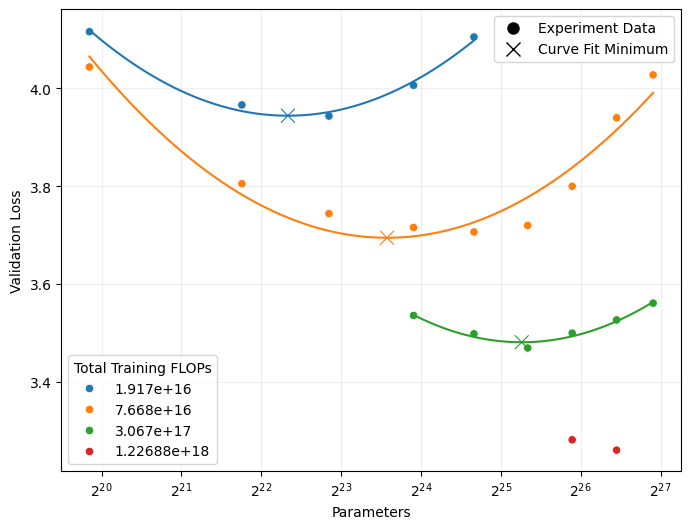

In [1318]:
fig, ax = plt.subplots(figsize=(8, 6))


g = sns.scatterplot(
    data=min_results,
    x="params",
    y="min_valid_loss",
    hue="total_flops",
    hue_order=total_flops,
    ax=ax,
    palette="tab10",
)

for i, flops in enumerate(total_flops):
    df = fit_params[fit_params.total_flops == flops]
    if len(df) == 0:
        continue
    x_line = np.linspace(df.xmin, df.xmax, num=100)
    y_line = log_loss_log_params_parabola(x_line, df.A.item(), df.B.item(), df.C.item())
    ax.plot(2**x_line, y_line, color=f"C{i}")

sns.scatterplot(
    data=fit_params,
    x="opt_param",
    y="opt_loss",
    hue="total_flops",
    palette="tab10",
    legend=False,
    marker="x",
    s=100,
    ax=ax
)

# xmin, xmax = ax.get_ylim()
# xmin = 3.0
# x = np.linspace(xmin, xmax)
# pred_param = 2**(intercept + slope*x)
# ax.plot(pred_param, x, color="black", alpha=0.5)


flops_legend = ax.get_legend()
flops_legend.set_title("Total Training FLOPs")

legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Experiment Data", markerfacecolor="black", markersize=10),
    Line2D([0], [0], marker="x", color="w", label="Curve Fit Minimum", markeredgecolor="black", markersize=10)
]
ax.legend(handles=legend_elements, loc="upper right")

ax.add_artist(flops_legend)

ax.grid(which="major", alpha=0.20)
ax.set_xscale("log", base=2)
ax.set_xlabel("Parameters")
ax.set_ylabel("Validation Loss")

plt.show()

## Scaling Laws

In [1436]:
log_C = np.log2(fit_params.total_flops)
log_N = np.log2(fit_params.opt_param)

lC_lN_slope, lC_lN_intercept = np.polyfit(log_C, log_N, 1)

In [1437]:
lC_lN_slope.item(), lC_lN_intercept.item()

(0.7320369408811697, -17.337777276443475)

In [1438]:
opt_tokens = fit_params.total_flops / fit_params.opt_flops_per_token
log_C = np.log2(fit_params.total_flops)
log_D = np.log2(opt_tokens.values)

lC_lD_slope, lC_lD_intercept = np.polyfit(log_C, log_D, 1)

In [1439]:
lC_lD_slope.item(), lC_lD_intercept.item()

(0.31345293759209536, -0.9996616727818676)